In [98]:
import pandas as pd

In [99]:
df = pd.read_csv('Student_AI_usage.csv')

In [100]:
df.columns

Index(['ID', 'Start time', 'Completion time', 'Email', 'Name',
       'Last modified time', 'Select your year group:',
       'Which AI platforms or tools have you used for schoolwork or homework? (Select all that apply)',
       'How often do you use AI tools for academic work?',
       'For which subjects do you most commonly use AI tools? (Select all that apply)',
       'How do you typically use AI tools for your schoolwork? (Select all that apply)',
       'When you use AI for homework, do you typically:',
       'How do you feel about using AI tools for schoolwork?',
       'How confident are you in your ability to use AI tools effectively and ethically?',
       'Do you currently declare when you've used AI tools in your homework or assignments?',
       'How aware do you think your teachers are of your AI usage?',
       'How do you feel about teachers using AI in their teaching, e.g. when preparing resources for lessons?',
       'What support would be most helpful from school

In [101]:
df = df.rename(columns={"Select your year group:": "Year",
                        "Which AI platforms or tools have you used for schoolwork or homework? (Select all that apply)": "Tools",
                        "How often do you use AI tools for academic work?": "Occurrence",
                        "For which subjects do you most commonly use AI tools? (Select all that apply)": "Subjects",
                        "How do you typically use AI tools for your schoolwork? (Select all that apply)": "Reasons",
                        "When you use AI for homework, do you typically:": "Scenario",
                        "How do you feel about using AI tools for schoolwork?": "Feeling",
                        "How confident are you in your ability to use AI tools effectively and ethically?": "Confidence",
                        "Do you currently declare when you've used AI tools in your homework or assignments?": "Declare",
                        "How aware do you think your teachers are of your AI usage?": "Teacher_awareness",
                        "How do you feel about teachers using AI in their teaching, e.g. when preparing resources for lessons?": "Teacher_usage",
                        "What support would be most helpful from school regarding AI use? (Select up to 3)": "Support",
                        "Have you ever been unsure whether your use of AI was appropriate for a particular assignment or task?": "Allowed",
                        "How did you first learn about using AI tools for schoolwork?": "Discovery",
                        "Do you primarily use AI tools on:": "Device",
                        "Are your parents/guardians aware that you use AI tools for schoolwork?": "Parent_awareness",
                        "What has prevented you from using AI tools more, or what concerns do you have? (Select all that apply)": "Concerns",
                        "Is there anything else you'd like us to know about your experience with AI tools, or suggestions for how the school could better support students in this area?": "Other_info"
               })

In [102]:
# examine our key variables first
for col in ['Occurrence', 'Declare', 'Parent_awareness', 'Subjects']:
    print(f"\n=== {col} ===")
    print(df[col].value_counts())
    print(f"Missing values: {df[col].isnull().sum()}")


=== Occurrence ===
Occurrence
Rarely                  217
Never                    60
Weekly                   59
Monthly                  58
Several times a week     27
Daily                    11
Name: count, dtype: int64
Missing values: 0

=== Declare ===
Declare
I'm not sure if I'm supposed to    174
Never                               77
Always                              50
Sometimes                           50
Rarely                              41
Usually                             40
Name: count, dtype: int64
Missing values: 0

=== Parent_awareness ===
Parent_awareness
Yes, they know but don't have strong opinions    118
Not applicable - I don't use AI tools            115
Yes, they know and are supportive                 93
I'm not sure if they know                         87
Yes, they know but have concerns                  12
No, they don't know                                7
Name: count, dtype: int64
Missing values: 0

=== Subjects ===
Subjects
Modern Foreign Languag

In [103]:
df['Subjects'].unique()

array(['Modern Foreign Languages;Humanities;', 'politics;',
       'Mathematics;Sciences (Biology, Chemistry, Physics);Computer Science;',
       'Sciences (Biology, Chemistry, Physics);Organisation;', 'N/.A;',
       'Humanities;',
       'Sciences (Biology, Chemistry, Physics);Mathematics;',
       ' English/Literature;Sciences (Biology, Chemistry, Physics);Humanities;',
       'Mathematics;Modern Foreign Languages;',
       ' English/Literature;Mathematics;', ' English/Literature;',
       'Mathematics;', 'none;', 'N/A;',
       'Modern Foreign Languages;Computer Science;',
       'Modern Foreign Languages;',
       ' English/Literature;Modern Foreign Languages;',
       'Humanities; English/Literature;',
       'Sciences (Biology, Chemistry, Physics);',
       ' English/Literature;Mathematics;Sciences (Biology, Chemistry, Physics);',
       ' English/Literature;Mathematics;Modern Foreign Languages;',
       'Computer Science; English/Literature;Mathematics;',
       ' English/Liter

In [104]:
# encode occurrence column
def encode_occurrence(value):
    occurrence_map = {
        'Daily': 5,
        'Several times a week': 4,
        'Weekly': 3,
        'Monthly': 2,
        'Rarely': 1,
        'Never': 0
    }
    return occurrence_map[value]


In [105]:
def encode_declare(value):
    declare_map = {
        'Always': 5,
        'Usually': 4,
        'Sometimes': 3,
        'Rarely': 2,
        "I'm not sure if I'm supposed to": 1,
        'Never': 0
    }
    return declare_map[value]

In [106]:
def encode_parent_awareness(value):
    parent_map = {
        'Yes, they know and are supportive': 3,
        'Yes, they know but don\'t have strong opinions': 3,
        'Yes, they know but have concerns': 3,
        "I'm not sure if they know": 2,
        "No, they don't know": 1,
        "Not applicable - I don't use AI tools": 0
    }
    return parent_map[value]

In [107]:
def count_subjects(value):
    if pd.isna(value) or value.strip() == '':
        return 0
    
    value_lower = value.lower().strip()
    
    # Clear "don't use" patterns
    dont_use_patterns = [
        "i don't use ai", "i dont use ai", "i do not use ai",
        "i don't use it", "i dont use it", 
        "never use", "dont use it",
        "i don't;", "i dont;", "i don't ", "i dont ",
        "never;", "none;", "n/a;", "n/.a;"
    ]
    
    if any(pattern in value_lower for pattern in dont_use_patterns):
        return 0
    
    if value.strip() in [';', ' ;', '']:
        return 0
    
    # Special cases that indicate usage
    usage_indicators = [
        "practice questions", "revision", "timetable", "flashcard", 
        "autocorrect", "translate", "understand", "grammer", "grammar"
    ]
    
    if any(indicator in value_lower for indicator in usage_indicators):
        return 1
    
    return value.count(';')

In [108]:
# Apply transformations
df['occurrence_encoded'] = df['Occurrence'].apply(encode_occurrence)
df['declare_encoded'] = df['Declare'].apply(encode_declare)
df['parent_awareness_encoded'] = df['Parent_awareness'].apply(encode_parent_awareness)
df['subject_count'] = df['Subjects'].apply(count_subjects)

# Create clustering dataset
clustering_data = df[['occurrence_encoded', 'subject_count', 'declare_encoded', 'parent_awareness_encoded']].copy()

print("Clustering dataset created!")
print(f"Shape: {clustering_data.shape}")
print(f"\nData types:\n{clustering_data.dtypes}")
print(f"\nBasic statistics:\n{clustering_data.describe()}")
print(f"\nFirst 10 rows:\n{clustering_data.head(10)}")

Clustering dataset created!
Shape: (432, 4)

Data types:
occurrence_encoded          int64
subject_count               int64
declare_encoded             int64
parent_awareness_encoded    int64
dtype: object

Basic statistics:
       occurrence_encoded  subject_count  declare_encoded  \
count          432.000000     432.000000       432.000000   
mean             1.557870       1.375000         1.888889   
std              1.217194       0.983919         1.623970   
min              0.000000       0.000000         0.000000   
25%              1.000000       1.000000         1.000000   
50%              1.000000       1.000000         1.000000   
75%              2.000000       2.000000         3.000000   
max              5.000000       8.000000         5.000000   

       parent_awareness_encoded  
count                432.000000  
mean                   1.967593  
std                    1.264862  
min                    0.000000  
25%                    0.000000  
50%                 

In [109]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Standardise the data
scaler = StandardScaler()
clustering_data_scaled = scaler.fit_transform(clustering_data)

print("Original data shape:", clustering_data.shape)
print("Scaled data shape:", clustering_data_scaled.shape)
print("\nOriginal data ranges:")
print(clustering_data.describe())
print("\nScaled data mean (should be ~0):")
print(clustering_data_scaled.mean(axis=0))
print("Scaled data std (should be ~1):")
print(clustering_data_scaled.std(axis=0))

Original data shape: (432, 4)
Scaled data shape: (432, 4)

Original data ranges:
       occurrence_encoded  subject_count  declare_encoded  \
count          432.000000     432.000000       432.000000   
mean             1.557870       1.375000         1.888889   
std              1.217194       0.983919         1.623970   
min              0.000000       0.000000         0.000000   
25%              1.000000       1.000000         1.000000   
50%              1.000000       1.000000         1.000000   
75%              2.000000       2.000000         3.000000   
max              5.000000       8.000000         5.000000   

       parent_awareness_encoded  
count                432.000000  
mean                   1.967593  
std                    1.264862  
min                    0.000000  
25%                    0.000000  
50%                    3.000000  
75%                    3.000000  
max                    3.000000  

Scaled data mean (should be ~0):
[-6.16790569e-17  2.46716228e

C:\Users\wimmabis1\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\wimmabis1\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\wimmabis1\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\wimmabis1\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmea

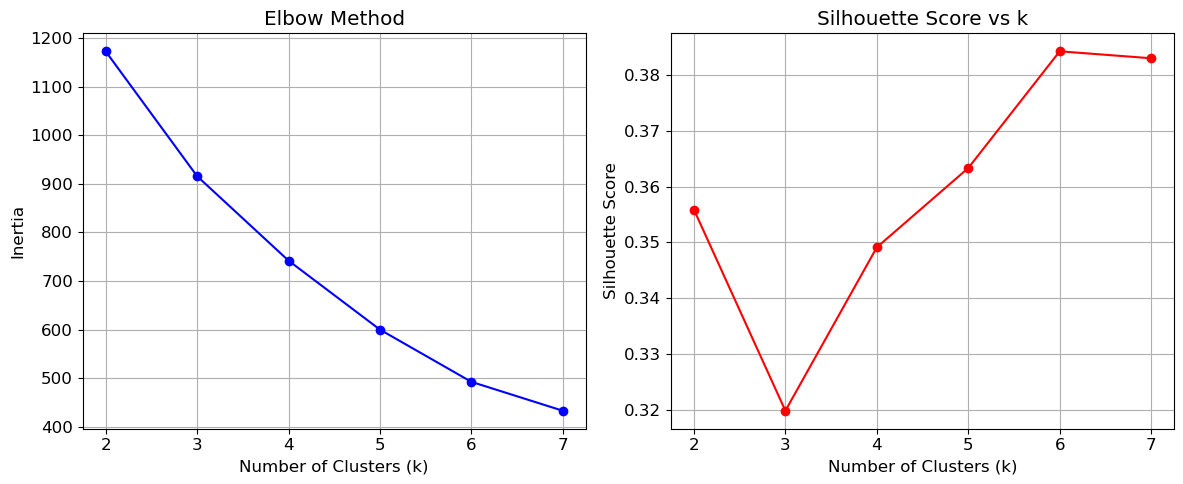

Silhouette scores for different k:
k=2: 0.356
k=3: 0.320
k=4: 0.349
k=5: 0.363
k=6: 0.384
k=7: 0.383


In [110]:
# Test different numbers of clusters
k_range = range(2, 8)
inertias = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(clustering_data_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(clustering_data_scaled, kmeans.labels_))

# Plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Elbow plot
ax1.plot(k_range, inertias, 'bo-')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method')
ax1.grid(True)

# Silhouette plot
ax2.plot(k_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score vs k')
ax2.grid(True)

plt.tight_layout()
plt.show()

print("Silhouette scores for different k:")
for k, score in zip(k_range, silhouette_scores):
    print(f"k={k}: {score:.3f}")

In [111]:
# Fit final K-means with k=4
final_kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
cluster_labels = final_kmeans.fit_predict(clustering_data_scaled)

# Add cluster labels to our original data
df['cluster'] = cluster_labels
clustering_data['cluster'] = cluster_labels

print(f"Cluster distribution:")
print(df['cluster'].value_counts().sort_index())

Cluster distribution:
cluster
0     71
1    100
2    209
3     52
Name: count, dtype: int64


C:\Users\wimmabis1\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [112]:
# Analyze each cluster's characteristics
cluster_analysis = clustering_data.groupby('cluster').agg({
    'occurrence_encoded': ['mean', 'std'],
    'subject_count': ['mean', 'std'], 
    'declare_encoded': ['mean', 'std'],
    'parent_awareness_encoded': ['mean', 'std']
}).round(2)

print("Cluster Characteristics (Original Scale):")
print(cluster_analysis)

print("\n" + "="*60)
print("CLUSTER INTERPRETATION:")
print("="*60)

for cluster_id in range(4):
    cluster_data = clustering_data[clustering_data['cluster'] == cluster_id]
    print(f"\n🔍 CLUSTER {cluster_id} (n={len(cluster_data)}):")
    print(f"  • Usage Frequency: {cluster_data['occurrence_encoded'].mean():.1f} (0=Never, 5=Daily)")
    print(f"  • Number of Subjects: {cluster_data['subject_count'].mean():.1f}")
    print(f"  • School Disclosure: {cluster_data['declare_encoded'].mean():.1f} (0=Never, 5=Always)")
    print(f"  • Parent Awareness: {cluster_data['parent_awareness_encoded'].mean():.1f} (0=N/A, 3=Yes)")

Cluster Characteristics (Original Scale):
        occurrence_encoded       subject_count       declare_encoded        \
                      mean   std          mean   std            mean   std   
cluster                                                                      
0                     0.59  0.62          0.68  0.65            0.58  0.62   
1                     3.42  0.79          2.08  1.27            1.66  1.30   
2                     1.21  0.48          1.43  0.68            1.78  1.43   
3                     0.69  0.67          0.77  0.73            4.54  0.67   

        parent_awareness_encoded        
                            mean   std  
cluster                                 
0                           0.07  0.26  
1                           2.69  0.60  
2                           2.71  0.47  
3                           0.19  0.60  

CLUSTER INTERPRETATION:

🔍 CLUSTER 0 (n=71):
  • Usage Frequency: 0.6 (0=Never, 5=Daily)
  • Number of Subjects: 0.7
  • Sc

In [115]:
# First, let's see what confidence responses we have
print("Confidence level responses:")
print(df['Confidence'].value_counts())
print("\nUnique values:")
print(df['Confidence'].unique())

# Encode confidence levels
def encode_confidence(value):
    confidence_map = {
        'Very confident': 4,
        'Quite confident': 3,
        'Somewhat confident': 2,
        'Not very confident': 1,
        'Not confident at all': 0
    }
    return confidence_map.get(value.strip(), None)

# Apply confidence encoding
df['confidence_encoded'] = df['Confidence'].apply(encode_confidence)

# Analyze confidence by cluster
confidence_by_cluster = df.groupby('cluster')['confidence_encoded'].agg(['mean', 'std', 'count']).round(2)
print("\nConfidence by Cluster:")
print(confidence_by_cluster)

# Create detailed breakdown
print("\n" + "="*60)
print("CONFIDENCE ANALYSIS BY CLUSTER:")
print("="*60)

cluster_names = [
    "Thoughtful Skeptics",
    "Pragmatic Power Users", 
    "Cautious Experimenters",
    "Rule-Followers"
]

for cluster_id in range(4):
    cluster_data = df[df['cluster'] == cluster_id]
    confidence_dist = cluster_data['Confidence'].value_counts()
    mean_confidence = cluster_data['confidence_encoded'].mean()
    
    print(f"\n🔍 {cluster_names[cluster_id]} (Cluster {cluster_id}):")
    print(f"  • Average Confidence: {mean_confidence:.2f}/4")
    print(f"  • Confidence Distribution:")
    for conf_level, count in confidence_dist.items():
        percentage = (count / len(cluster_data)) * 100
        print(f"    - {conf_level}: {count} students ({percentage:.1f}%)")

Confidence level responses:
Confidence
Somewhat confident                                           206
 Very confident                                              115
Unsure what "effective and ethical" means in this context     62
Not very confident                                            37
Not confident at all                                          12
Name: count, dtype: int64

Unique values:
[' Very confident' 'Somewhat confident' 'Not very confident'
 'Unsure what "effective and ethical" means in this context'
 'Not confident at all']

Confidence by Cluster:
         mean   std  count
cluster                   
0        2.15  1.10     53
1        2.69  1.13     93
2        2.46  1.04    181
3        2.30  1.41     43

CONFIDENCE ANALYSIS BY CLUSTER:

🔍 Thoughtful Skeptics (Cluster 0):
  • Average Confidence: 2.15/4
  • Confidence Distribution:
    - Somewhat confident: 31 students (43.7%)
    - Unsure what "effective and ethical" means in this context: 18 students (25.4%)
 

In [116]:
# Get detailed confidence breakdown
print("=== DETAILED CONFIDENCE ANALYSIS ===")

cluster_names = ["Thoughtful Skeptics", "Pragmatic Power Users", "Cautious Experimenters", "Rule-Followers"]

for cluster_id in range(4):
    cluster_data = df[df['cluster'] == cluster_id]
    mean_confidence = cluster_data['confidence_encoded'].mean()
    std_confidence = cluster_data['confidence_encoded'].std()
    confidence_dist = cluster_data['Confidence'].value_counts()
    
    print(f"\n🔍 {cluster_names[cluster_id]} (Cluster {cluster_id}, n={len(cluster_data)}):")
    print(f"  • Average Confidence: {mean_confidence:.2f}/4 (std: {std_confidence:.2f})")
    print(f"  • Confidence Distribution:")
    for conf_level, count in confidence_dist.items():
        percentage = (count / len(cluster_data)) * 100
        print(f"    - {conf_level}: {count} students ({percentage:.1f}%)")
    
    # Calculate high confidence percentage (Very confident)
    high_confidence = cluster_data[cluster_data['Confidence'] == ' Very confident'].shape[0]
    high_conf_pct = (high_confidence / len(cluster_data)) * 100
    print(f"  • High Confidence Rate: {high_conf_pct:.1f}%")

# Show the "Unsure about effective and ethical" breakdown
print(f"\n=== 'UNSURE ABOUT EFFECTIVE AND ETHICAL' BREAKDOWN ===")
unsure_by_cluster = df[df['Confidence'] == 'Unsure what "effective and ethical" means in this context'].groupby('cluster').size()
for cluster_id in range(4):
    cluster_size = len(df[df['cluster'] == cluster_id])
    unsure_count = unsure_by_cluster.get(cluster_id, 0)
    unsure_pct = (unsure_count / cluster_size) * 100
    print(f"Cluster {cluster_id} ({cluster_names[cluster_id]}): {unsure_count} students ({unsure_pct:.1f}%)")

=== DETAILED CONFIDENCE ANALYSIS ===

🔍 Thoughtful Skeptics (Cluster 0, n=71):
  • Average Confidence: 2.15/4 (std: 1.10)
  • Confidence Distribution:
    - Somewhat confident: 31 students (43.7%)
    - Unsure what "effective and ethical" means in this context: 18 students (25.4%)
    -  Very confident: 11 students (15.5%)
    - Not very confident: 8 students (11.3%)
    - Not confident at all: 3 students (4.2%)
  • High Confidence Rate: 15.5%

🔍 Pragmatic Power Users (Cluster 1, n=100):
  • Average Confidence: 2.69/4 (std: 1.13)
  • Confidence Distribution:
    - Somewhat confident: 48 students (48.0%)
    -  Very confident: 37 students (37.0%)
    - Unsure what "effective and ethical" means in this context: 7 students (7.0%)
    - Not very confident: 6 students (6.0%)
    - Not confident at all: 2 students (2.0%)
  • High Confidence Rate: 37.0%

🔍 Cautious Experimenters (Cluster 2, n=209):
  • Average Confidence: 2.46/4 (std: 1.04)
  • Confidence Distribution:
    - Somewhat confiden

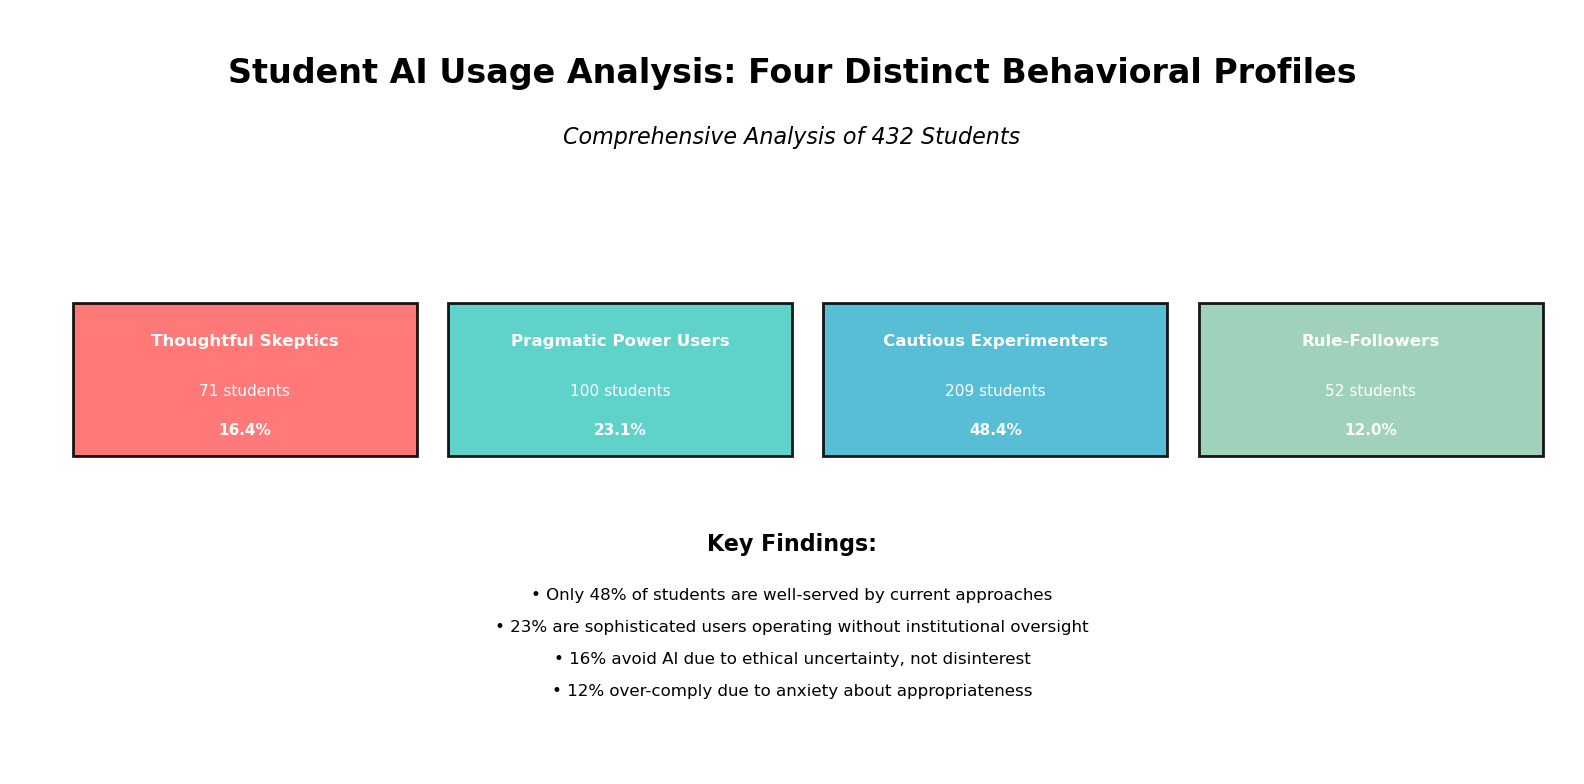

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import Rectangle

# Set up professional styling
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 12

# Define our data
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
cluster_names = ['Thoughtful Skeptics', 'Pragmatic Power Users', 'Cautious Experimenters', 'Rule-Followers']
cluster_sizes = [71, 100, 209, 52]

# 1. EXECUTIVE SUMMARY DASHBOARD
fig, ax = plt.subplots(figsize=(16, 8))
ax.set_xlim(0, 10)
ax.set_ylim(0, 6)
ax.axis('off')

# Main title
ax.text(5, 5.5, 'Student AI Usage Analysis: Four Distinct Behavioral Profiles', 
        ha='center', va='center', fontsize=24, fontweight='bold')

# Subtitle
ax.text(5, 5, 'Comprehensive Analysis of 432 Students', 
        ha='center', va='center', fontsize=16, style='italic')

# Create cluster overview boxes
box_width = 2.2
box_height = 1.2
start_x = 0.4

for i, (name, size, color) in enumerate(zip(cluster_names, cluster_sizes, colors)):
    x = start_x + i * 2.4
    
    # Main box
    rect = Rectangle((x, 2.5), box_width, box_height, 
                    facecolor=color, alpha=0.9, edgecolor='black', linewidth=2)
    ax.add_patch(rect)
    
    # Cluster name
    ax.text(x + box_width/2, 3.4, name, 
            ha='center', va='center', fontsize=12, fontweight='bold', color='white')
    
    # Size
    ax.text(x + box_width/2, 3.0, f'{size} students', 
            ha='center', va='center', fontsize=11, color='white')
    
    # Percentage
    ax.text(x + box_width/2, 2.7, f'{size/432*100:.1f}%', 
            ha='center', va='center', fontsize=11, color='white', fontweight='bold')

# Key insights
ax.text(5, 1.8, 'Key Findings:', ha='center', va='center', fontsize=16, fontweight='bold')

insights = [
    "• Only 48% of students are well-served by current approaches",
    "• 23% are sophisticated users operating without institutional oversight", 
    "• 16% avoid AI due to ethical uncertainty, not disinterest",
    "• 12% over-comply due to anxiety about appropriateness"
]

for i, insight in enumerate(insights):
    ax.text(5, 1.4 - i*0.25, insight, ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.savefig('01_executive_summary_dashboard.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()
plt.close()

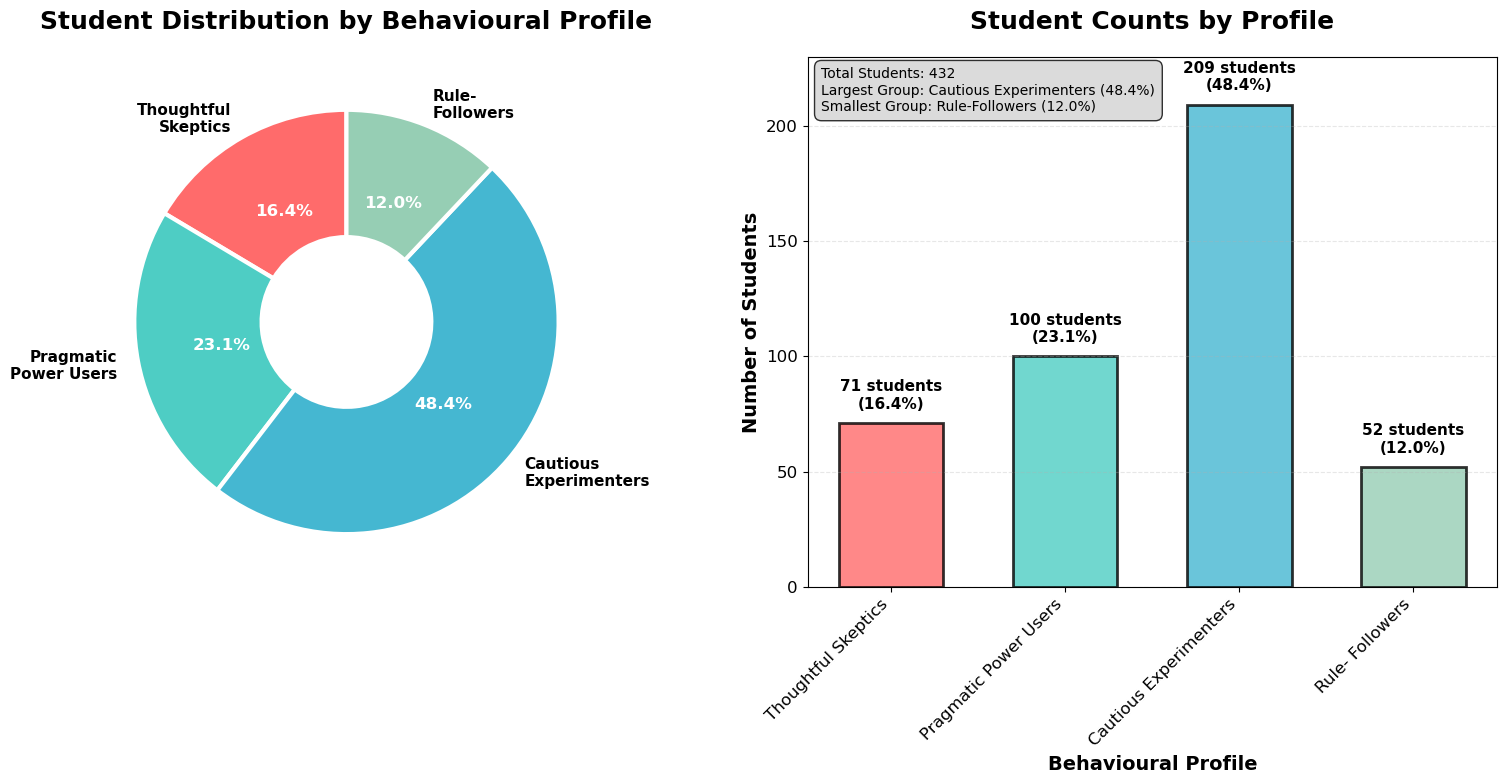

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set up professional styling
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 12

# Define our data
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
cluster_names = ['Thoughtful\nSkeptics', 'Pragmatic\nPower Users', 'Cautious\nExperimenters', 'Rule-\nFollowers']
cluster_sizes = [71, 100, 209, 52]

# CLUSTER DISTRIBUTION CHART
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Left side - Donut chart
wedges, texts, autotexts = ax1.pie(cluster_sizes, labels=cluster_names, colors=colors, 
                                  autopct='%1.1f%%', startangle=90, 
                                  wedgeprops=dict(width=0.6, edgecolor='white', linewidth=3))

# Style donut chart
ax1.set_title('Student Distribution by Behavioural Profile', fontsize=18, fontweight='bold', pad=20)

# Make percentages bold and larger
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(12)

# labels bold
for text in texts:
    text.set_fontweight('bold')
    text.set_fontsize(11)

# Right side - Bar chart with detailed info
bars = ax2.bar(range(4), cluster_sizes, color=colors, alpha=0.8, 
               edgecolor='black', linewidth=2, width=0.6)

ax2.set_title('Student Counts by Profile', fontsize=18, fontweight='bold', pad=20)
ax2.set_ylabel('Number of Students', fontsize=14, fontweight='bold')
ax2.set_xlabel('Behavioural Profile', fontsize=14, fontweight='bold')
ax2.set_xticks(range(4))
ax2.set_xticklabels([name.replace('\n', ' ') for name in cluster_names], rotation=45, ha='right')
ax2.set_ylim(0, max(cluster_sizes) * 1.1)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for i, (bar, size) in enumerate(zip(bars, cluster_sizes)):
    height = bar.get_height()
    percentage = size/432*100
    ax2.text(bar.get_x() + bar.get_width()/2., height + 5, 
             f'{size} students\n({percentage:.1f}%)', 
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add summary statistics
ax2.text(0.02, 0.98, f'Total Students: {sum(cluster_sizes)}\nLargest Group: Cautious Experimenters ({209/432*100:.1f}%)\nSmallest Group: Rule-Followers ({52/432*100:.1f}%)', 
         transform=ax2.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))

plt.tight_layout()
plt.savefig('02_cluster_distribution.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()
plt.close()

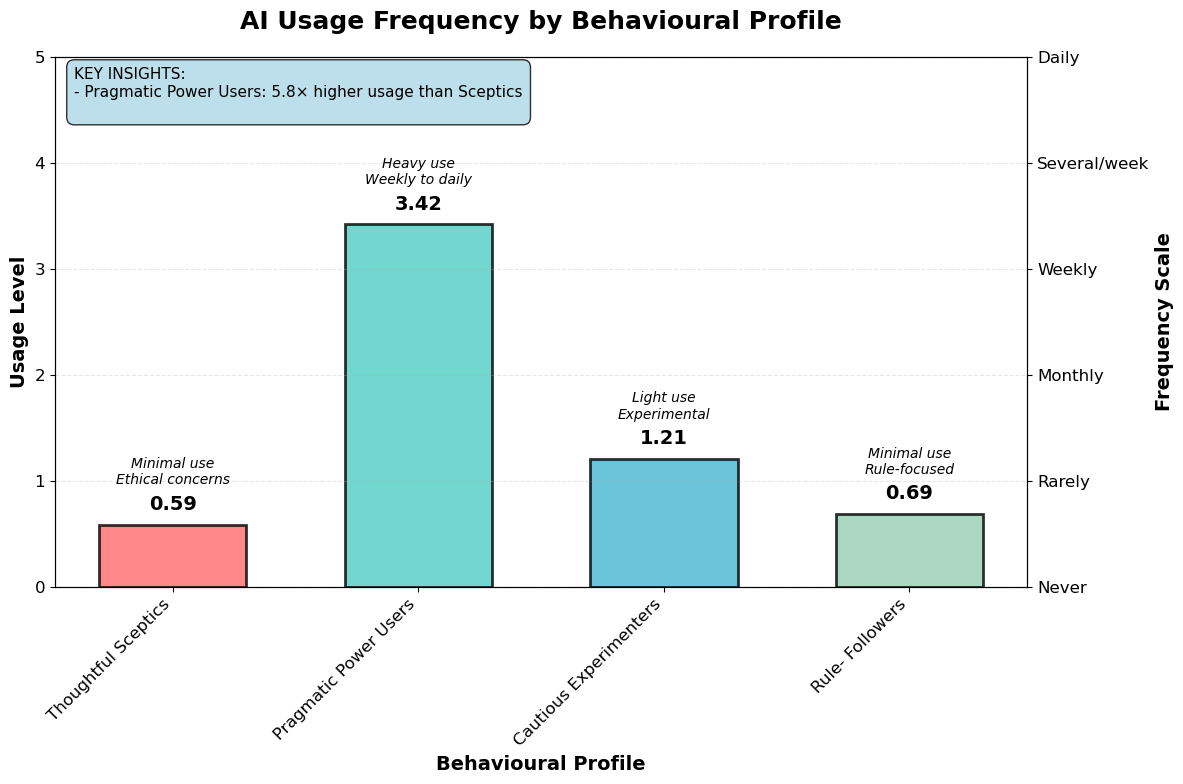

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set up professional styling
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 12

# Define data
colours = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
cluster_names = ['Thoughtful\nSceptics', 'Pragmatic\nPower Users', 'Cautious\nExperimenters', 'Rule-\nFollowers']
usage_means = [0.59, 3.42, 1.21, 0.69]

# USAGE FREQUENCY COMPARISON
fig, ax = plt.subplots(figsize=(12, 8))

# Create bars
bars = ax.bar(range(4), usage_means, color=colours, alpha=0.8, 
              edgecolor='black', linewidth=2, width=0.6)

ax.set_title('AI Usage Frequency by Behavioural Profile', fontsize=18, fontweight='bold', pad=20)
ax.set_ylabel('Usage Level', fontsize=14, fontweight='bold')
ax.set_xlabel('Behavioural Profile', fontsize=14, fontweight='bold')
ax.set_xticks(range(4))
ax.set_xticklabels([name.replace('\n', ' ') for name in cluster_names], rotation=45, ha='right')
ax.set_ylim(0, 5)

# Add reference on right y-axis
ax_right = ax.twinx()
ax_right.set_ylim(0, 5)
ax_right.set_ylabel('Frequency Scale', fontsize=14, fontweight='bold')
ax_right.set_yticks([0, 1, 2, 3, 4, 5])
ax_right.set_yticklabels(['Never', 'Rarely', 'Monthly', 'Weekly', 'Several/week', 'Daily'])

# Add horizontal grid lines for reference
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_yticks([0, 1, 2, 3, 4, 5])

# Add value labels and interpretations
interpretations = [
    'Minimal use\nEthical concerns',
    'Heavy use\nWeekly to daily',
    'Light use\nExperimental',
    'Minimal use\nRule-focused'
]

for i, (bar, value, interpretation) in enumerate(zip(bars, usage_means, interpretations)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.1, 
            f'{value:.2f}', ha='center', va='bottom', fontsize=14, fontweight='bold')
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.35, 
            interpretation, ha='center', va='bottom', fontsize=10, style='italic')

# Add key insights
insights_text = """KEY INSIGHTS:
- Pragmatic Power Users: 5.8× higher usage than Sceptics
"""

ax.text(0.02, 0.98, insights_text, transform=ax.transAxes, fontsize=11, 
        verticalalignment='top', bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))

plt.tight_layout()
plt.savefig('03_usage_frequency_comparison.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()
plt.close()

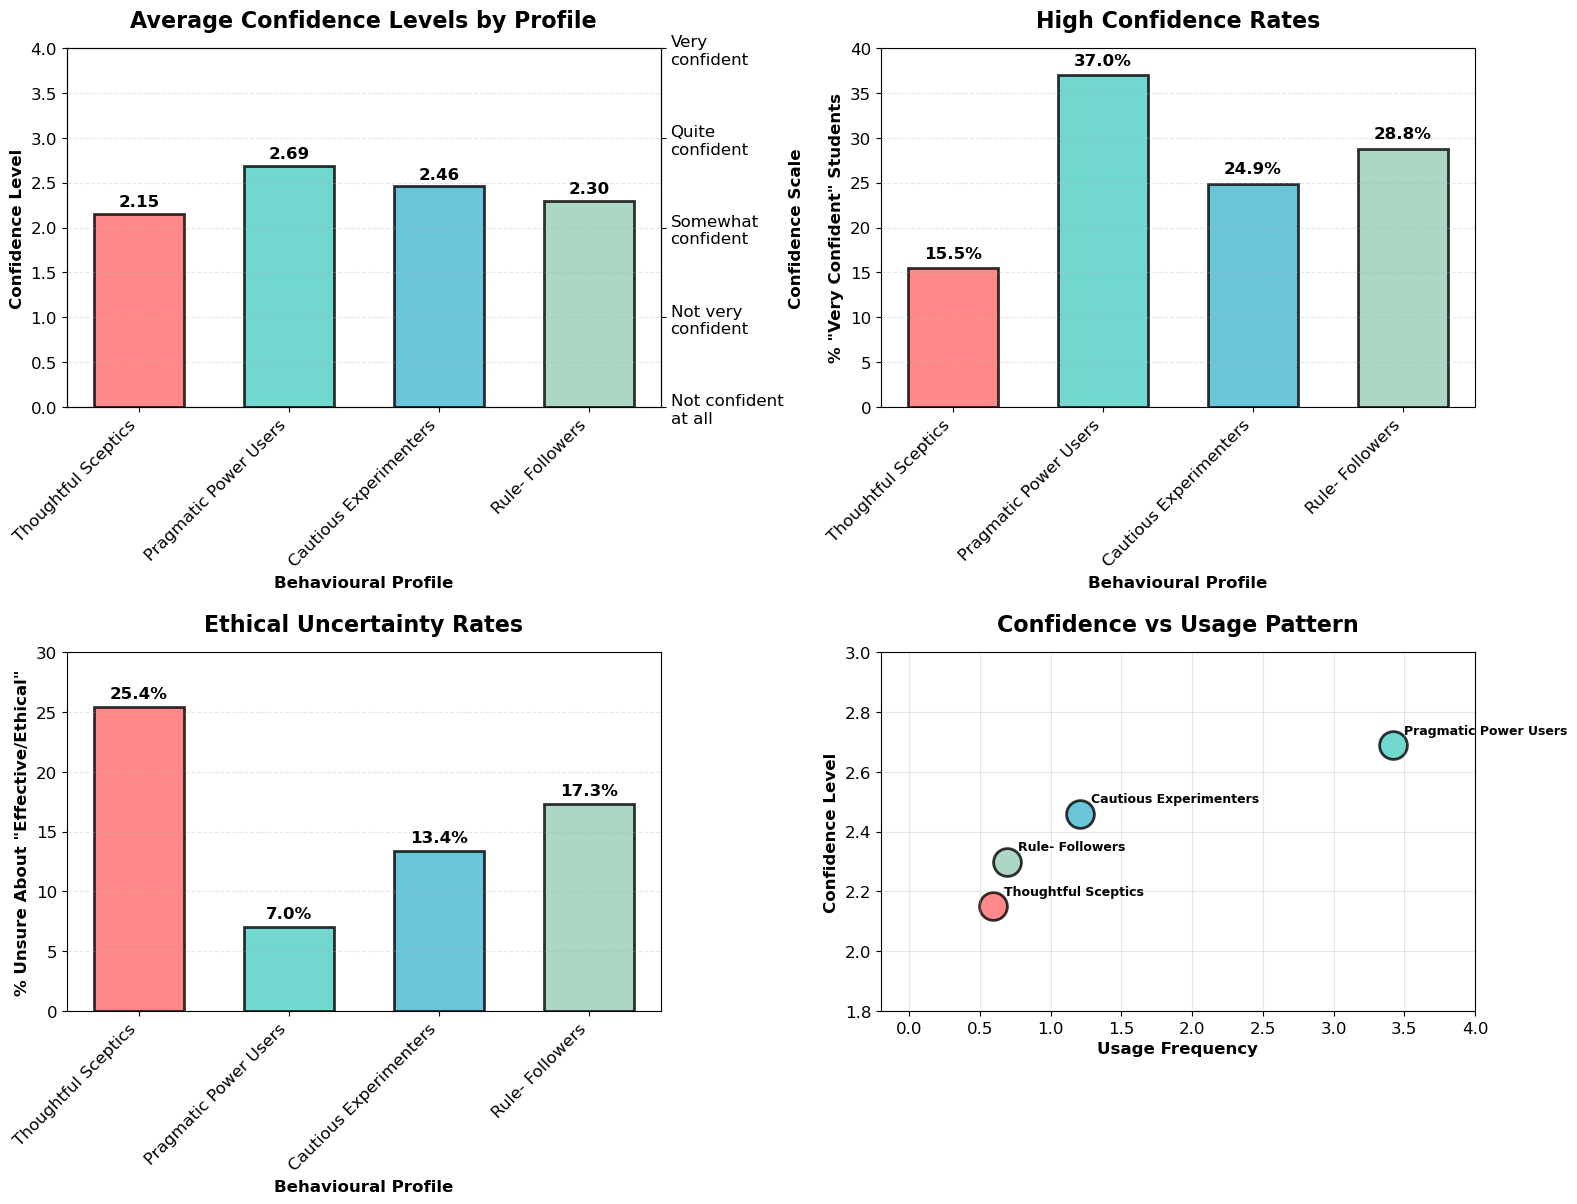

In [120]:
# styling
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 12

# Define  data
colours = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
cluster_names = ['Thoughtful\nSceptics', 'Pragmatic\nPower Users', 'Cautious\nExperimenters', 'Rule-\nFollowers']
confidence_means = [2.15, 2.69, 2.46, 2.30]
high_conf_rates = [15.5, 37.0, 24.9, 28.8]
ethical_uncertain = [25.4, 7.0, 13.4, 17.3]

# CONFIDENCE ANALYSIS
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Top left - Average confidence levels
bars1 = ax1.bar(range(4), confidence_means, color=colours, alpha=0.8, 
                edgecolor='black', linewidth=2, width=0.6)

ax1.set_title('Average Confidence Levels by Profile', fontsize=16, fontweight='bold', pad=15)
ax1.set_ylabel('Confidence Level', fontsize=12, fontweight='bold')
ax1.set_xlabel('Behavioural Profile', fontsize=12, fontweight='bold')
ax1.set_xticks(range(4))
ax1.set_xticklabels([name.replace('\n', ' ') for name in cluster_names], rotation=45, ha='right')
ax1.set_ylim(0, 4)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Add confidence scale
ax1_right = ax1.twinx()
ax1_right.set_ylim(0, 4)
ax1_right.set_ylabel('Confidence Scale', fontsize=12, fontweight='bold')
ax1_right.set_yticks([0, 1, 2, 3, 4])
ax1_right.set_yticklabels(['Not confident\nat all', 'Not very\nconfident', 'Somewhat\nconfident', 'Quite\nconfident', 'Very\nconfident'])

# Add value labels
for i, (bar, value) in enumerate(zip(bars1, confidence_means)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.05, 
             f'{value:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Top right - confidence rates
bars2 = ax2.bar(range(4), high_conf_rates, color=colours, alpha=0.8, 
                edgecolor='black', linewidth=2, width=0.6)

ax2.set_title('High Confidence Rates', fontsize=16, fontweight='bold', pad=15)
ax2.set_ylabel('% "Very Confident" Students', fontsize=12, fontweight='bold')
ax2.set_xlabel('Behavioural Profile', fontsize=12, fontweight='bold')
ax2.set_xticks(range(4))
ax2.set_xticklabels([name.replace('\n', ' ') for name in cluster_names], rotation=45, ha='right')
ax2.set_ylim(0, 40)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

for i, (bar, value) in enumerate(zip(bars2, high_conf_rates)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.8, 
             f'{value:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Bottom left - uncertainty rates
bars3 = ax3.bar(range(4), ethical_uncertain, color=colours, alpha=0.8, 
                edgecolor='black', linewidth=2, width=0.6)

ax3.set_title('Ethical Uncertainty Rates', fontsize=16, fontweight='bold', pad=15)
ax3.set_ylabel('% Unsure About "Effective/Ethical"', fontsize=12, fontweight='bold')
ax3.set_xlabel('Behavioural Profile', fontsize=12, fontweight='bold')
ax3.set_xticks(range(4))
ax3.set_xticklabels([name.replace('\n', ' ') for name in cluster_names], rotation=45, ha='right')
ax3.set_ylim(0, 30)
ax3.grid(axis='y', alpha=0.3, linestyle='--')

for i, (bar, value) in enumerate(zip(bars3, ethical_uncertain)):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.5, 
             f'{value:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Bottom right Confidence vs Usage scatter
usage_means = [0.59, 3.42, 1.21, 0.69]
for i, (usage, confidence, colour, name) in enumerate(zip(usage_means, confidence_means, colours, cluster_names)):
    ax4.scatter(usage, confidence, s=400, c=colour, alpha=0.8, edgecolor='black', linewidth=2)
    ax4.annotate(name.replace('\n', ' '), (usage, confidence), 
                xytext=(8, 8), textcoords='offset points', fontsize=9, fontweight='bold')

ax4.set_xlabel('Usage Frequency', fontsize=12, fontweight='bold')
ax4.set_ylabel('Confidence Level', fontsize=12, fontweight='bold')
ax4.set_title('Confidence vs Usage Pattern', fontsize=16, fontweight='bold', pad=15)
ax4.grid(True, alpha=0.3)
ax4.set_xlim(-0.2, 4)
ax4.set_ylim(1.8, 3)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.savefig('04_confidence_analysis.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()
plt.close()

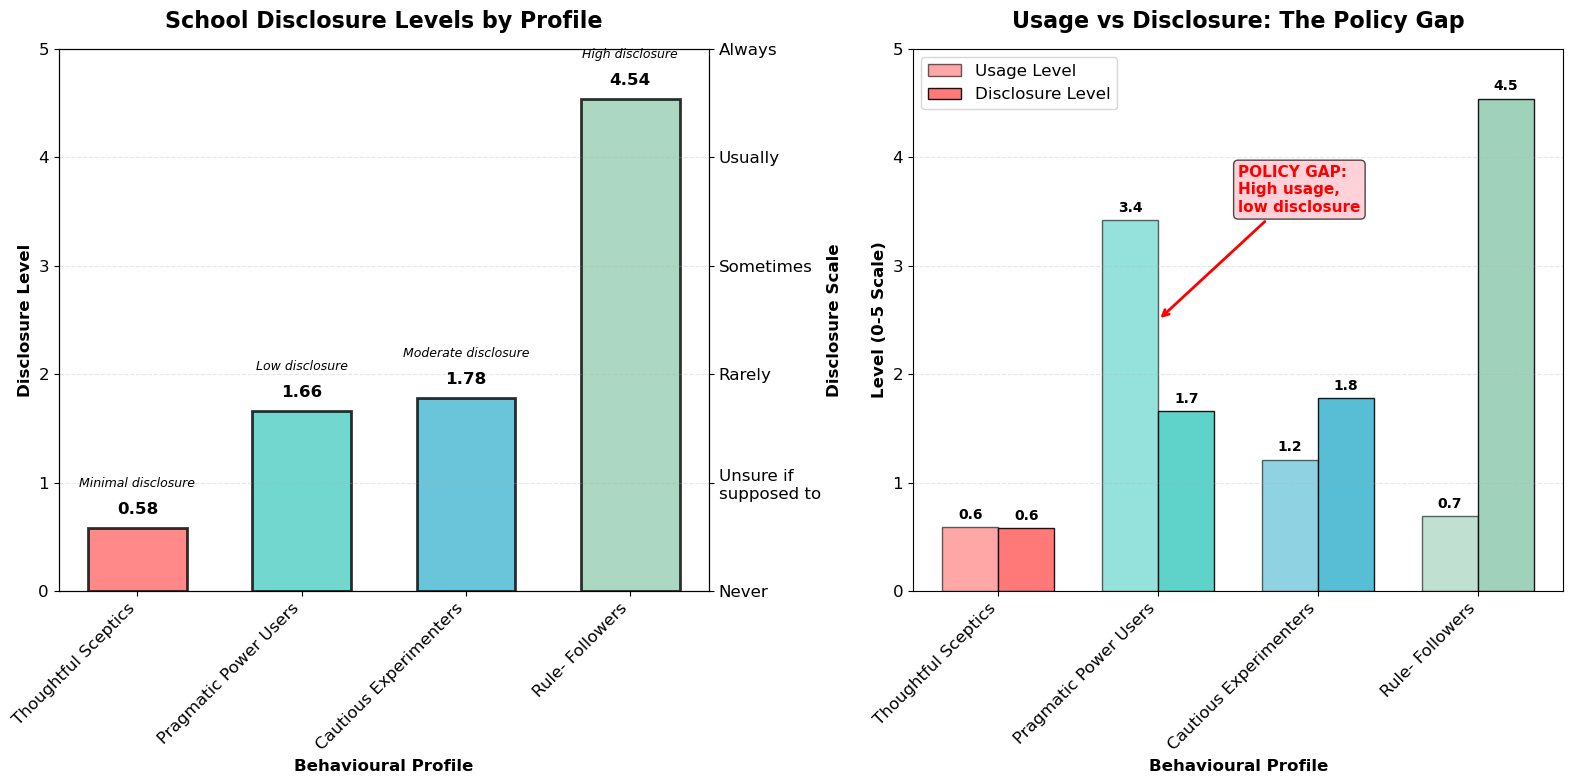

In [121]:
#styling
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 12

# Define  data
colours = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
cluster_names = ['Thoughtful\nSceptics', 'Pragmatic\nPower Users', 'Cautious\nExperimenters', 'Rule-\nFollowers']
disclosure_means = [0.58, 1.66, 1.78, 4.54]
parent_awareness = [0.07, 2.69, 2.71, 0.19]

# DISCLOSURE PATTERNS
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Left side - disclosure levels
bars1 = ax1.bar(range(4), disclosure_means, color=colours, alpha=0.8, 
                edgecolor='black', linewidth=2, width=0.6)

ax1.set_title('School Disclosure Levels by Profile', fontsize=16, fontweight='bold', pad=15)
ax1.set_ylabel('Disclosure Level', fontsize=12, fontweight='bold')
ax1.set_xlabel('Behavioural Profile', fontsize=12, fontweight='bold')
ax1.set_xticks(range(4))
ax1.set_xticklabels([name.replace('\n', ' ') for name in cluster_names], rotation=45, ha='right')
ax1.set_ylim(0, 5)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# disclosure scale reference
ax1_right = ax1.twinx()
ax1_right.set_ylim(0, 5)
ax1_right.set_ylabel('Disclosure Scale', fontsize=12, fontweight='bold')
ax1_right.set_yticks([0, 1, 2, 3, 4, 5])
ax1_right.set_yticklabels(['Never', 'Unsure if\nsupposed to', 'Rarely', 'Sometimes', 'Usually', 'Always'])

# Add value labels
interpretations = [
    'Minimal disclosure',
    'Low disclosure',
    'Moderate disclosure',
    'High disclosure'
]

for i, (bar, value, interpretation) in enumerate(zip(bars1, disclosure_means, interpretations)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1, 
             f'{value:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.35, 
             interpretation, ha='center', va='bottom', fontsize=9, style='italic')

# Right side disclosure vs usage
usage_means = [0.59, 3.42, 1.21, 0.69]

x = np.arange(len(cluster_names))
width = 0.35

bars2 = ax2.bar(x - width/2, usage_means, width, label='Usage Level', 
                color=colours, alpha=0.6, edgecolor='black', linewidth=1)
bars3 = ax2.bar(x + width/2, disclosure_means, width, label='Disclosure Level', 
                color=colours, alpha=0.9, edgecolor='black', linewidth=1)

ax2.set_title('Usage vs Disclosure: The Policy Gap', fontsize=16, fontweight='bold', pad=15)
ax2.set_ylabel('Level (0-5 Scale)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Behavioural Profile', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels([name.replace('\n', ' ') for name in cluster_names], rotation=45, ha='right')
ax2.set_ylim(0, 5)
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.legend()

# Add labels
for i, (bar2, bar3, usage, disclosure) in enumerate(zip(bars2, bars3, usage_means, disclosure_means)):
    height2 = bar2.get_height()
    height3 = bar3.get_height()
    ax2.text(bar2.get_x() + bar2.get_width()/2., height2 + 0.05, 
             f'{usage:.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    ax2.text(bar3.get_x() + bar3.get_width()/2., height3 + 0.05, 
             f'{disclosure:.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# show the policy gap
ax2.annotate('POLICY GAP:\nHigh usage,\nlow disclosure', 
            xy=(1, 2.5), xytext=(1.5, 3.5),
            arrowprops=dict(arrowstyle='->', color='red', lw=2),
            fontsize=11, fontweight='bold', color='red',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="pink", alpha=0.7))

plt.tight_layout()
plt.savefig('05_school_disclosure_patterns.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()
plt.close()

In [122]:
# Subject analysis
import re

# Define main subjects to look for
main_subjects = [
    'Modern Foreign Languages',
    'Mathematics',
    'Sciences',
    'English',
    'Literature', 
    'Humanities',
    'Computer Science',
    'Creative subjects',
    'Design Technology',
    'Religious Studies',
    'Economics',
    'Politics'
]

# look at overall subject usage
subject_counts = {}
for subject in main_subjects:
    if subject == 'Sciences':
        # Look for various science mentions
        count = df['Subjects'].str.contains('Sciences|Biology|Chemistry|Physics', case=False, na=False).sum()
    elif subject == 'English':
        count = df['Subjects'].str.contains('English|Literature', case=False, na=False).sum()
    elif subject == 'Creative subjects':
        count = df['Subjects'].str.contains('Creative|Art|Music|Drama', case=False, na=False).sum()
    else:
        count = df['Subjects'].str.contains(subject, case=False, na=False).sum()
    
    percentage = (count / len(df)) * 100
    subject_counts[subject] = {'count': count, 'percentage': percentage}

# by cluster
for cluster_id in range(4):
    cluster_data = df[df['cluster'] == cluster_id]
    print(f"\nCluster {cluster_id} ({cluster_names[cluster_id].replace(chr(10), ' ')}):")
    
    for subject in main_subjects:
        if subject == 'Sciences':
            count = cluster_data['Subjects'].str.contains('Sciences|Biology|Chemistry|Physics', case=False, na=False).sum()
        elif subject == 'English':
            count = cluster_data['Subjects'].str.contains('English|Literature', case=False, na=False).sum()
        elif subject == 'Creative subjects':
            count = cluster_data['Subjects'].str.contains('Creative|Art|Music|Drama', case=False, na=False).sum()
        else:
            count = cluster_data['Subjects'].str.contains(subject, case=False, na=False).sum()
        
        percentage = (count / len(cluster_data)) * 100 if len(cluster_data) > 0 else 0
        print(f"  {subject}: {count} students ({percentage:.1f}%)")


Cluster 0 (Thoughtful Sceptics):
  Modern Foreign Languages: 14 students (19.7%)
  Mathematics: 3 students (4.2%)
  Sciences: 5 students (7.0%)
  English: 9 students (12.7%)
  Literature: 9 students (12.7%)
  Humanities: 4 students (5.6%)
  Computer Science: 1 students (1.4%)
  Creative subjects: 2 students (2.8%)
  Design Technology: 1 students (1.4%)
  Religious Studies: 0 students (0.0%)
  Economics: 0 students (0.0%)
  Politics: 0 students (0.0%)

Cluster 1 (Pragmatic Power Users):
  Modern Foreign Languages: 45 students (45.0%)
  Mathematics: 27 students (27.0%)
  Sciences: 39 students (39.0%)
  English: 38 students (38.0%)
  Literature: 38 students (38.0%)
  Humanities: 36 students (36.0%)
  Computer Science: 10 students (10.0%)
  Creative subjects: 4 students (4.0%)
  Design Technology: 5 students (5.0%)
  Religious Studies: 0 students (0.0%)
  Economics: 1 students (1.0%)
  Politics: 1 students (1.0%)

Cluster 2 (Cautious Experimenters):
  Modern Foreign Languages: 110 student

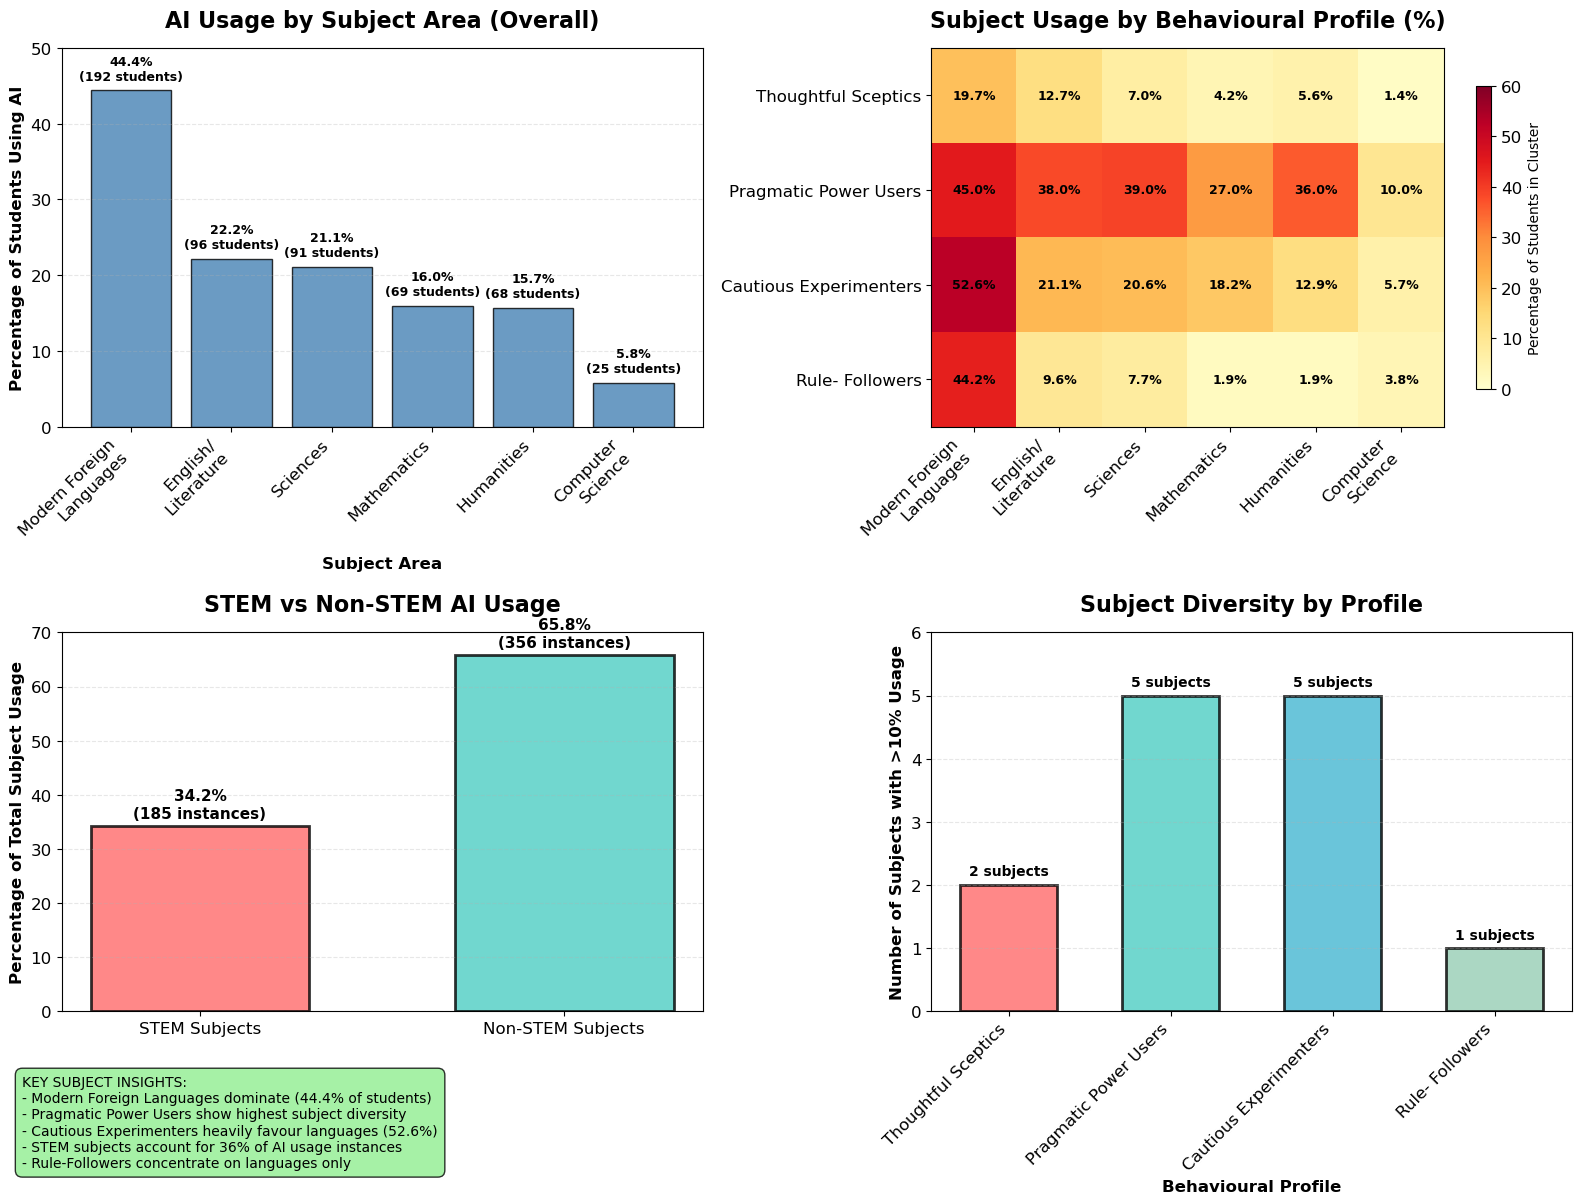

In [123]:
# Set up professional styling
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 12

# Define our data from the analysis
colours = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
cluster_names = ['Thoughtful\nSceptics', 'Pragmatic\nPower Users', 'Cautious\nExperimenters', 'Rule-\nFollowers']

# Overall subject usage data
subjects = ['Modern Foreign\nLanguages', 'English/\nLiterature', 'Sciences', 'Mathematics', 'Humanities', 'Computer\nScience']
overall_counts = [192, 96, 91, 69, 68, 25]
overall_percentages = [44.4, 22.2, 21.1, 16.0, 15.7, 5.8]

# Subject usage by cluster (percentages within each cluster)
cluster_subject_data = {
    'Thoughtful Sceptics': [19.7, 12.7, 7.0, 4.2, 5.6, 1.4],
    'Pragmatic Power Users': [45.0, 38.0, 39.0, 27.0, 36.0, 10.0],
    'Cautious Experimenters': [52.6, 21.1, 20.6, 18.2, 12.9, 5.7],
    'Rule-Followers': [44.2, 9.6, 7.7, 1.9, 1.9, 3.8]
}

# 7. SUBJECT USAGE ANALYSIS
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Top left - Overall subject popularity
bars1 = ax1.bar(range(len(subjects)), overall_percentages, 
                color='steelblue', alpha=0.8, edgecolor='black', linewidth=1)

ax1.set_title('AI Usage by Subject Area (Overall)', fontsize=16, fontweight='bold', pad=15)
ax1.set_ylabel('Percentage of Students Using AI', fontsize=12, fontweight='bold')
ax1.set_xlabel('Subject Area', fontsize=12, fontweight='bold')
ax1.set_xticks(range(len(subjects)))
ax1.set_xticklabels(subjects, rotation=45, ha='right')
ax1.set_ylim(0, 50)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

for i, (bar, percentage, count) in enumerate(zip(bars1, overall_percentages, overall_counts)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 1, 
             f'{percentage:.1f}%\n({count} students)', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Top right - Subject usage by cluster (heatmap)
cluster_matrix = np.array([
    cluster_subject_data['Thoughtful Sceptics'],
    cluster_subject_data['Pragmatic Power Users'],
    cluster_subject_data['Cautious Experimenters'],
    cluster_subject_data['Rule-Followers']
])

im = ax2.imshow(cluster_matrix, cmap='YlOrRd', aspect='auto', vmin=0, vmax=60)
ax2.set_title('Subject Usage by Behavioural Profile (%)', fontsize=16, fontweight='bold', pad=15)
ax2.set_xticks(range(len(subjects)))
ax2.set_xticklabels(subjects, rotation=45, ha='right')
ax2.set_yticks(range(4))
ax2.set_yticklabels([name.replace('\n', ' ') for name in cluster_names])

# Add percentage values to heatmap
for i in range(4):
    for j in range(len(subjects)):
        text = ax2.text(j, i, f'{cluster_matrix[i, j]:.1f}%', 
                       ha="center", va="center", color="black", fontweight='bold', fontsize=9)

# Add colorbar
cbar = plt.colorbar(im, ax=ax2, shrink=0.8)
cbar.set_label('Percentage of Students in Cluster', fontsize=10)

# Bottom left - STEM vs Non-STEM analysis
stem_subjects = ['Sciences', 'Mathematics', 'Computer Science']
non_stem_subjects = ['Modern Foreign Languages', 'English/Literature', 'Humanities']

stem_totals = [91, 69, 25]  # Total students using AI in these subjects
non_stem_totals = [192, 96, 68]

stem_total = sum(stem_totals)
non_stem_total = sum(non_stem_totals)

categories = ['STEM Subjects', 'Non-STEM Subjects']
totals = [stem_total, non_stem_total]
percentages = [stem_total/(stem_total+non_stem_total)*100, non_stem_total/(stem_total+non_stem_total)*100]

bars3 = ax3.bar(categories, percentages, color=['#FF6B6B', '#4ECDC4'], alpha=0.8, 
                edgecolor='black', linewidth=2, width=0.6)

ax3.set_title('STEM vs Non-STEM AI Usage', fontsize=16, fontweight='bold', pad=15)
ax3.set_ylabel('Percentage of Total Subject Usage', fontsize=12, fontweight='bold')
ax3.set_ylim(0, 70)
ax3.grid(axis='y', alpha=0.3, linestyle='--')

for i, (bar, percentage, total) in enumerate(zip(bars3, percentages, totals)):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 1, 
             f'{percentage:.1f}%\n({total} instances)', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Bottom right - Subject diversity by cluster
cluster_diversity = []
cluster_names_clean = ['Thoughtful Sceptics', 'Pragmatic Power Users', 'Cautious Experimenters', 'Rule-Followers']

for cluster_name in cluster_names_clean:
    # Count subjects with >10% usage in each cluster
    high_usage_subjects = sum(1 for percentage in cluster_subject_data[cluster_name] if percentage > 10)
    cluster_diversity.append(high_usage_subjects)

bars4 = ax4.bar(range(4), cluster_diversity, color=colours, alpha=0.8, 
                edgecolor='black', linewidth=2, width=0.6)

ax4.set_title('Subject Diversity by Profile', fontsize=16, fontweight='bold', pad=15)
ax4.set_ylabel('Number of Subjects with >10% Usage', fontsize=12, fontweight='bold')
ax4.set_xlabel('Behavioural Profile', fontsize=12, fontweight='bold')
ax4.set_xticks(range(4))
ax4.set_xticklabels([name.replace('\n', ' ') for name in cluster_names], rotation=45, ha='right')
ax4.set_ylim(0, 6)
ax4.grid(axis='y', alpha=0.3, linestyle='--')

for i, (bar, diversity) in enumerate(zip(bars4, cluster_diversity)):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.1, 
             f'{diversity} subjects', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add key insights
insights_text = """KEY SUBJECT INSIGHTS:
- Modern Foreign Languages dominate (44.4% of students)
- Pragmatic Power Users show highest subject diversity
- Cautious Experimenters heavily favour languages (52.6%)
- STEM subjects account for 36% of AI usage instances
- Rule-Followers concentrate on languages only"""

fig.text(0.02, 0.02, insights_text, fontsize=10, 
         bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgreen", alpha=0.8))

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.savefig('07_subject_usage_analysis.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()
plt.close()

In [124]:
# tool analysis

tools_column = df['Tools']


# unique values to understand format
unique_tools = tools_column.dropna().unique()

# Define main AI tools to look for based on common mentions
main_tools = [
    'ChatGPT',
    'Google Bard',
    'Gemini', 
    'Grammarly',
    'Google Translate',
    'Language translation tools',
    'Claude',
    'Copilot',
    'Bing AI'
]

tool_counts = {}

for tool in main_tools:
    if tool == 'Google Bard':
        # Look for Bard or Google Bard
        count = tools_column.str.contains('Bard|Google Bard', case=False, na=False).sum()
    elif tool == 'Language translation tools':
        # Look for translation tools
        count = tools_column.str.contains('translation|translate', case=False, na=False).sum()
    elif tool == 'Grammarly':
        # Look for Grammarly mentions
        count = tools_column.str.contains('Grammarly', case=False, na=False).sum()
    else:
        count = tools_column.str.contains(tool, case=False, na=False).sum()
    
    percentage = (count / len(df)) * 100
    tool_counts[tool] = {'count': count, 'percentage': percentage}

cluster_names_clean = ['Thoughtful Sceptics', 'Pragmatic Power Users', 'Cautious Experimenters', 'Rule-Followers']

for cluster_id in range(4):
    cluster_data = df[df['cluster'] == cluster_id]
    
    for tool in main_tools:
        if tool == 'Google Bard':
            count = cluster_data['Tools'].str.contains('Bard|Google Bard', case=False, na=False).sum()
        elif tool == 'Language translation tools':
            count = cluster_data['Tools'].str.contains('translation|translate', case=False, na=False).sum()
        elif tool == 'Grammarly':
            count = cluster_data['Tools'].str.contains('Grammarly', case=False, na=False).sum()
        else:
            count = cluster_data['Tools'].str.contains(tool, case=False, na=False).sum()
        
        percentage = (count / len(cluster_data)) * 100 if len(cluster_data) > 0 else 0

for cluster_id in range(4):
    cluster_data = df[df['cluster'] == cluster_id]
    cluster_tools = cluster_data['Tools'].dropna()
    
    # Count average number of tools per student (count semicolons)
    avg_tools = cluster_tools.str.count(';').mean()
    max_tools = cluster_tools.str.count(';').max()

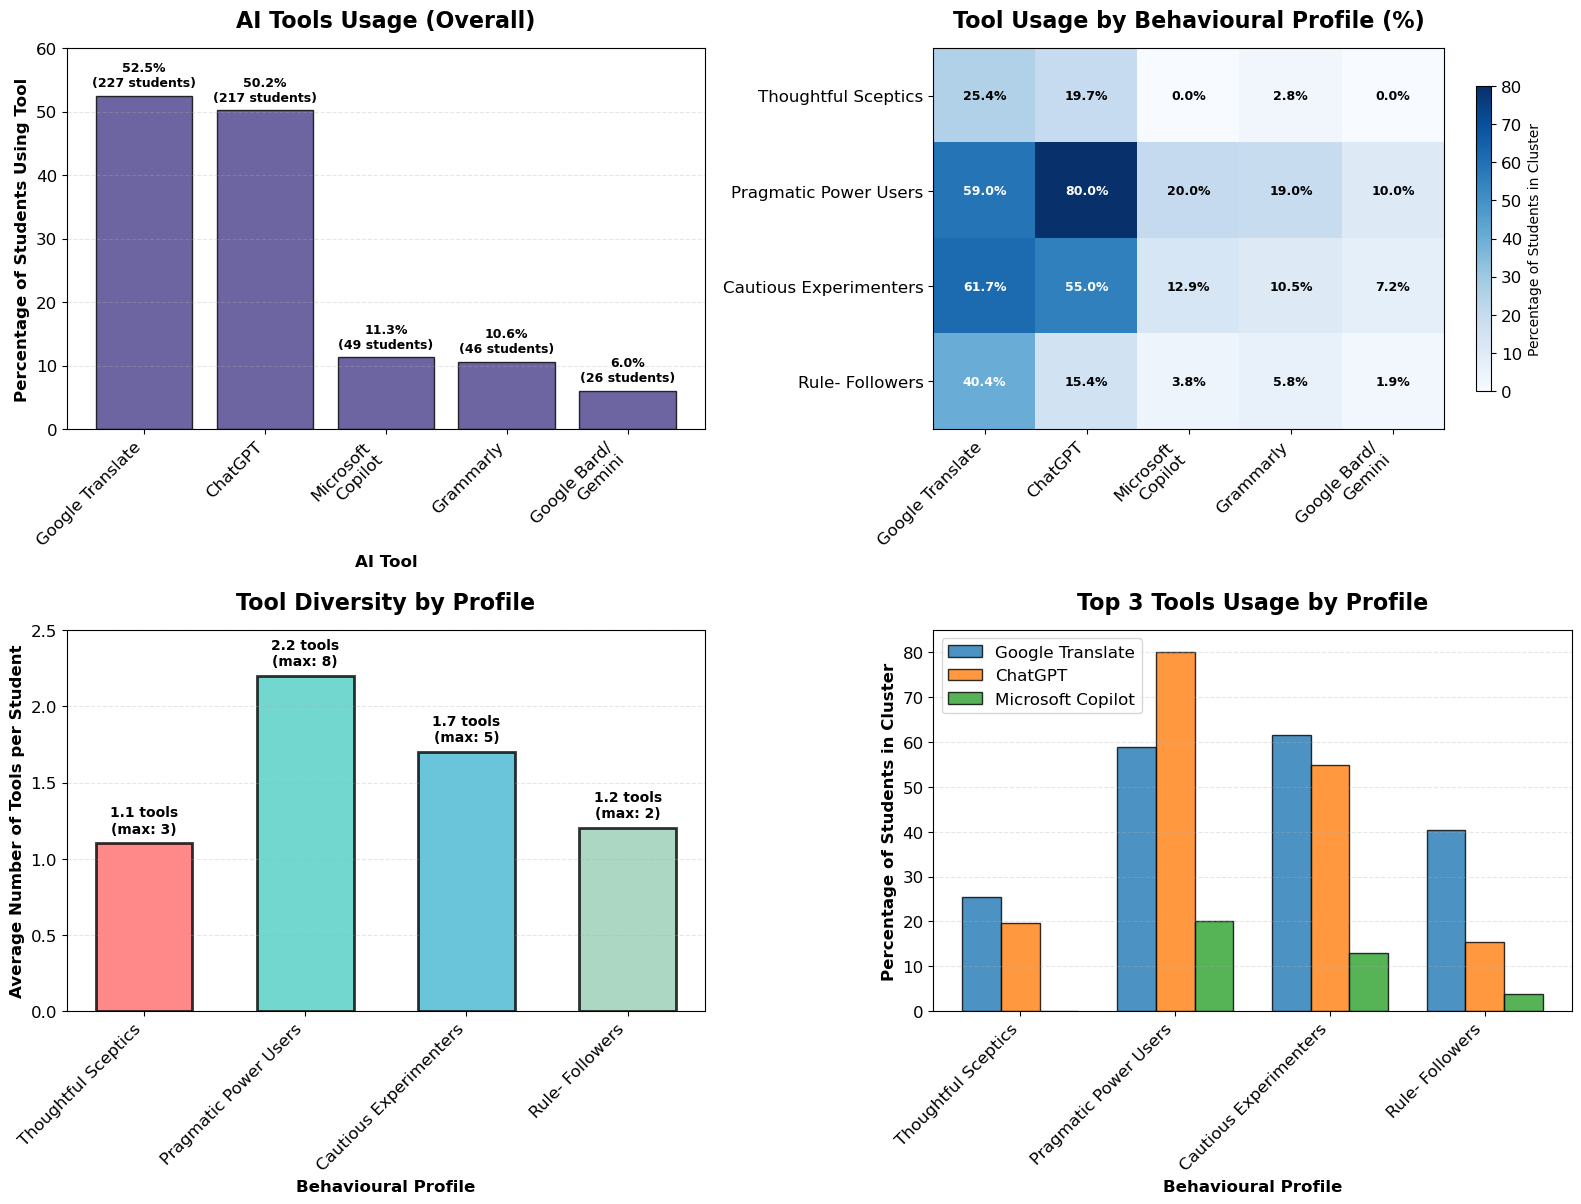

In [126]:
# setup  styling
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 12

# Define data
colours = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
cluster_names = ['Thoughtful\nSceptics', 'Pragmatic\nPower Users', 'Cautious\nExperimenters', 'Rule-\nFollowers']

# Overall tool usage data
tools = ['Google Translate', 'ChatGPT', 'Microsoft\nCopilot', 'Grammarly', 'Google Bard/\nGemini']
overall_counts = [227, 217, 49, 46, 26]
overall_percentages = [52.5, 50.2, 11.3, 10.6, 6.0]

# Tool usage by cluster
cluster_tool_data = {
    'Thoughtful Sceptics': [25.4, 19.7, 0.0, 2.8, 0.0],
    'Pragmatic Power Users': [59.0, 80.0, 20.0, 19.0, 10.0],
    'Cautious Experimenters': [61.7, 55.0, 12.9, 10.5, 7.2],
    'Rule-Followers': [40.4, 15.4, 3.8, 5.8, 1.9]
}

# Tool diversity data
tool_diversity = [1.1, 2.2, 1.7, 1.2]  # Average tools per student
max_tools = [3, 8, 5, 2]  # Maximum tools used by one student

# AI TOOLS USAGE ANALYSIS
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Top left - Overall tool popularity
bars1 = ax1.bar(range(len(tools)), overall_percentages, 
                color='darkslateblue', alpha=0.8, edgecolor='black', linewidth=1)

ax1.set_title('AI Tools Usage (Overall)', fontsize=16, fontweight='bold', pad=15)
ax1.set_ylabel('Percentage of Students Using Tool', fontsize=12, fontweight='bold')
ax1.set_xlabel('AI Tool', fontsize=12, fontweight='bold')
ax1.set_xticks(range(len(tools)))
ax1.set_xticklabels(tools, rotation=45, ha='right')
ax1.set_ylim(0, 60)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

for i, (bar, percentage, count) in enumerate(zip(bars1, overall_percentages, overall_counts)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 1, 
             f'{percentage:.1f}%\n({count} students)', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Top right heatmap of usage by cluster 
cluster_matrix = np.array([
    cluster_tool_data['Thoughtful Sceptics'],
    cluster_tool_data['Pragmatic Power Users'],
    cluster_tool_data['Cautious Experimenters'],
    cluster_tool_data['Rule-Followers']
])

im = ax2.imshow(cluster_matrix, cmap='Blues', aspect='auto', vmin=0, vmax=80)
ax2.set_title('Tool Usage by Behavioural Profile (%)', fontsize=16, fontweight='bold', pad=15)
ax2.set_xticks(range(len(tools)))
ax2.set_xticklabels(tools, rotation=45, ha='right')
ax2.set_yticks(range(4))
ax2.set_yticklabels([name.replace('\n', ' ') for name in cluster_names])


for i in range(4):
    for j in range(len(tools)):
        text = ax2.text(j, i, f'{cluster_matrix[i, j]:.1f}%', 
                       ha="center", va="center", color="white" if cluster_matrix[i, j] > 40 else "black", 
                       fontweight='bold', fontsize=9)

cbar = plt.colorbar(im, ax=ax2, shrink=0.8)
cbar.set_label('Percentage of Students in Cluster', fontsize=10)

# Bottom left diversity comparison
bars3 = ax3.bar(range(4), tool_diversity, color=colours, alpha=0.8, 
                edgecolor='black', linewidth=2, width=0.6)

ax3.set_title('Tool Diversity by Profile', fontsize=16, fontweight='bold', pad=15)
ax3.set_ylabel('Average Number of Tools per Student', fontsize=12, fontweight='bold')
ax3.set_xlabel('Behavioural Profile', fontsize=12, fontweight='bold')
ax3.set_xticks(range(4))
ax3.set_xticklabels([name.replace('\n', ' ') for name in cluster_names], rotation=45, ha='right')
ax3.set_ylim(0, 2.5)
ax3.grid(axis='y', alpha=0.3, linestyle='--')

for i, (bar, diversity, max_tool) in enumerate(zip(bars3, tool_diversity, max_tools)):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.05, 
             f'{diversity:.1f} tools\n(max: {max_tool})', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Bottom right tools comparison across clusters
# Show the top 3 tools (Google Translate, ChatGPT, Microsoft Copilot) across clusters
top_tools = ['Google Translate', 'ChatGPT', 'Microsoft Copilot']
top_tools_data = np.array([
    [25.4, 59.0, 61.7, 40.4],  # Google translate info
    [19.7, 80.0, 55.0, 15.4],  # Chatgpt
    [0.0, 20.0, 12.9, 3.8]     # Copilot
])

x = np.arange(len(cluster_names))
width = 0.25

for i, (tool, data) in enumerate(zip(top_tools, top_tools_data)):
    bars = ax4.bar(x + i*width, data, width, label=tool, alpha=0.8, edgecolor='black', linewidth=1)

ax4.set_title('Top 3 Tools Usage by Profile', fontsize=16, fontweight='bold', pad=15)
ax4.set_ylabel('Percentage of Students in Cluster', fontsize=12, fontweight='bold')
ax4.set_xlabel('Behavioural Profile', fontsize=12, fontweight='bold')
ax4.set_xticks(x + width)
ax4.set_xticklabels([name.replace('\n', ' ') for name in cluster_names], rotation=45, ha='right')
ax4.set_ylim(0, 85)
ax4.grid(axis='y', alpha=0.3, linestyle='--')
ax4.legend(loc='upper left')

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.savefig('08_ai_tools_analysis.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()
plt.close()

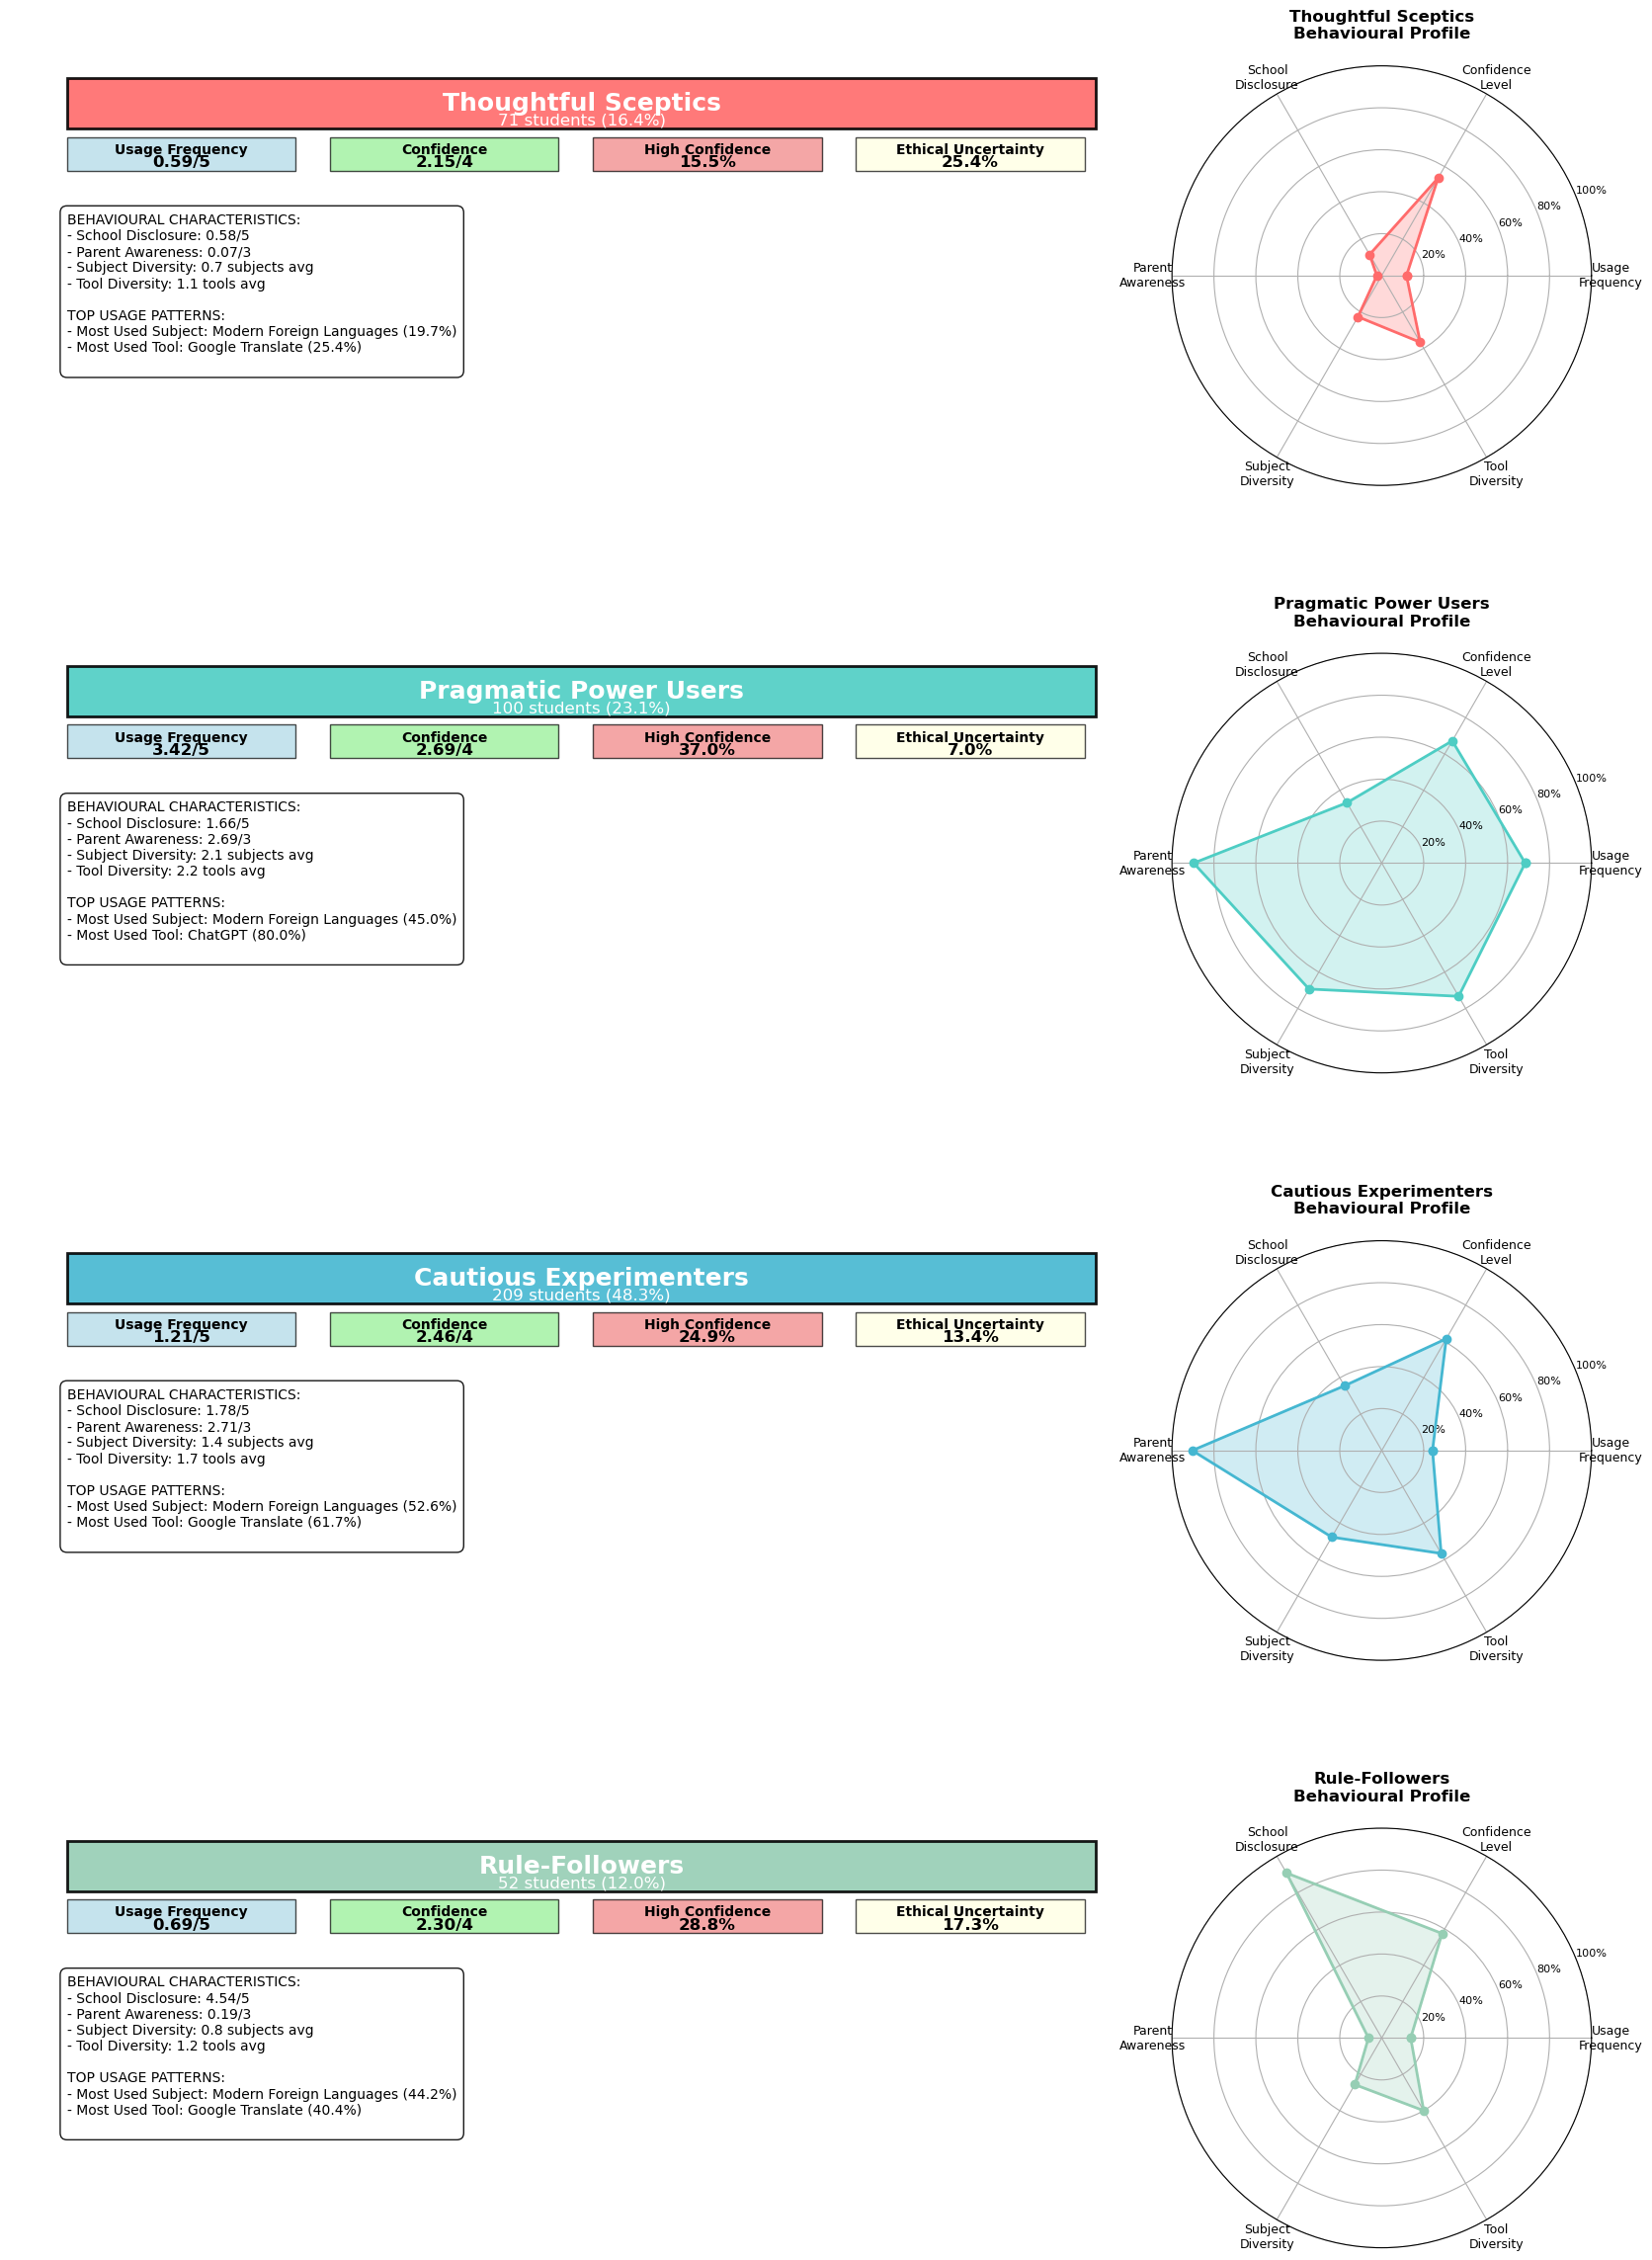

In [128]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import Rectangle

# Set up professional styling
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 11

# Define our comprehensive data
colours = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
cluster_names = ['Thoughtful Sceptics', 'Pragmatic Power Users', 'Cautious Experimenters', 'Rule-Followers']

# Complete profile data for each cluster
cluster_profiles = {
    'Thoughtful Sceptics': {
        'size': 71,
        'percentage': 16.4,
        'usage_frequency': 0.59,
        'confidence': 2.15,
        'high_confidence_rate': 15.5,
        'ethical_uncertainty': 25.4,
        'school_disclosure': 0.58,
        'parent_awareness': 0.07,
        'subject_diversity': 0.68,
        'tool_diversity': 1.1,
        'top_subject': 'Modern Foreign Languages (19.7%)',
        'top_tool': 'Google Translate (25.4%)',
    },
    'Pragmatic Power Users': {
        'size': 100,
        'percentage': 23.1,
        'usage_frequency': 3.42,
        'confidence': 2.69,
        'high_confidence_rate': 37.0,
        'ethical_uncertainty': 7.0,
        'school_disclosure': 1.66,
        'parent_awareness': 2.69,
        'subject_diversity': 2.08,
        'tool_diversity': 2.2,
        'top_subject': 'Modern Foreign Languages (45.0%)',
        'top_tool': 'ChatGPT (80.0%)',
    },
    'Cautious Experimenters': {
        'size': 209,
        'percentage': 48.3,
        'usage_frequency': 1.21,
        'confidence': 2.46,
        'high_confidence_rate': 24.9,
        'ethical_uncertainty': 13.4,
        'school_disclosure': 1.78,
        'parent_awareness': 2.71,
        'subject_diversity': 1.43,
        'tool_diversity': 1.7,
        'top_subject': 'Modern Foreign Languages (52.6%)',
        'top_tool': 'Google Translate (61.7%)',
    },
    'Rule-Followers': {
        'size': 52,
        'percentage': 12.0,
        'usage_frequency': 0.69,
        'confidence': 2.30,
        'high_confidence_rate': 28.8,
        'ethical_uncertainty': 17.3,
        'school_disclosure': 4.54,
        'parent_awareness': 0.19,
        'subject_diversity': 0.77,
        'tool_diversity': 1.2,
        'top_subject': 'Modern Foreign Languages (44.2%)',
        'top_tool': 'Google Translate (40.4%)',
    }
}

# INDIVIDUAL CLUSTER PROFILES
fig = plt.figure(figsize=(20, 24))

# Create individual profile for each cluster
for i, (cluster_name, data) in enumerate(cluster_profiles.items()):
    row_height = 6.5
    top_margin = 26
    current_y = top_margin - (i * row_height)

    
    # Create subplot for each cluster (4 rows, 2 columns per row)
    ax_main = plt.subplot(4, 2, i*2 + 1)
    ax_radar = plt.subplot(4, 2, i*2 + 2, projection='polar')
    
    # Main profile information (left side)
    ax_main.set_xlim(0, 10)
    ax_main.set_ylim(0, 10)
    ax_main.axis('off')
    
    # Cluster header
    header_rect = Rectangle((0.5, 8.5), 9, 1.2, facecolor=colours[i], alpha=0.9, edgecolor='black', linewidth=2)
    ax_main.add_patch(header_rect)
    ax_main.text(5, 9.1, f'{cluster_name}', ha='center', va='center', fontsize=18, fontweight='bold', color='white')
    ax_main.text(5, 8.7, f'{data["size"]} students ({data["percentage"]:.1f}%)', ha='center', va='center', fontsize=12, color='white')
    
    # Key metrics boxes
    metrics_y = 7.5
    box_width = 2.0
    box_height = 0.8
    
    # Usage frequency
    usage_rect = Rectangle((0.5, metrics_y), box_width, box_height, facecolor='lightblue', alpha=0.7, edgecolor='black')
    ax_main.add_patch(usage_rect)
    ax_main.text(1.5, metrics_y + 0.5, 'Usage Frequency', ha='center', va='center', fontsize=10, fontweight='bold')
    ax_main.text(1.5, metrics_y + 0.2, f'{data["usage_frequency"]:.2f}/5', ha='center', va='center', fontsize=12, fontweight='bold')
    
    # Confidence
    conf_rect = Rectangle((2.8, metrics_y), box_width, box_height, facecolor='lightgreen', alpha=0.7, edgecolor='black')
    ax_main.add_patch(conf_rect)
    ax_main.text(3.8, metrics_y + 0.5, 'Confidence', ha='center', va='center', fontsize=10, fontweight='bold')
    ax_main.text(3.8, metrics_y + 0.2, f'{data["confidence"]:.2f}/4', ha='center', va='center', fontsize=12, fontweight='bold')
    
    # High confidence rate
    high_conf_rect = Rectangle((5.1, metrics_y), box_width, box_height, facecolor='lightcoral', alpha=0.7, edgecolor='black')
    ax_main.add_patch(high_conf_rect)
    ax_main.text(6.1, metrics_y + 0.5, 'High Confidence', ha='center', va='center', fontsize=10, fontweight='bold')
    ax_main.text(6.1, metrics_y + 0.2, f'{data["high_confidence_rate"]:.1f}%', ha='center', va='center', fontsize=12, fontweight='bold')
    
    # Ethical uncertainty
    ethical_rect = Rectangle((7.4, metrics_y), box_width, box_height, facecolor='lightyellow', alpha=0.7, edgecolor='black')
    ax_main.add_patch(ethical_rect)
    ax_main.text(8.4, metrics_y + 0.5, 'Ethical Uncertainty', ha='center', va='center', fontsize=10, fontweight='bold')
    ax_main.text(8.4, metrics_y + 0.2, f'{data["ethical_uncertainty"]:.1f}%', ha='center', va='center', fontsize=12, fontweight='bold')
    
    # Detailed information
    details_text = f"""BEHAVIOURAL CHARACTERISTICS:
- School Disclosure: {data['school_disclosure']:.2f}/5
- Parent Awareness: {data['parent_awareness']:.2f}/3
- Subject Diversity: {data['subject_diversity']:.1f} subjects avg
- Tool Diversity: {data['tool_diversity']:.1f} tools avg

TOP USAGE PATTERNS:
- Most Used Subject: {data['top_subject']}
- Most Used Tool: {data['top_tool']}
"""
    
    ax_main.text(0.5, 6.5, details_text, ha='left', va='top', fontsize=10, 
                bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.9, edgecolor='black'))
    
    # Radar chart (right side)
    categories = ['Usage\nFrequency', 'Confidence\nLevel', 'School\nDisclosure', 'Parent\nAwareness', 'Subject\nDiversity', 'Tool\nDiversity']
    values = [
        data['usage_frequency'] / 5 * 100,  # Normalize to 0-100
        data['confidence'] / 4 * 100,
        data['school_disclosure'] / 5 * 100,
        data['parent_awareness'] / 3 * 100,
        data['subject_diversity'] / 3 * 100,  # Normalize based on reasonable max
        data['tool_diversity'] / 3 * 100  # Normalize based on reasonable max
    ]
    
    # Close the radar chart
    values += values[:1]
    
    # Calculate angles for radar chart
    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]
    
    # Plot radar chart
    ax_radar.plot(angles, values, 'o-', linewidth=2, label=cluster_name, color=colours[i])
    ax_radar.fill(angles, values, alpha=0.25, color=colours[i])
    ax_radar.set_xticks(angles[:-1])
    ax_radar.set_xticklabels(categories, fontsize=9)
    ax_radar.set_ylim(0, 100)
    ax_radar.set_yticks([20, 40, 60, 80, 100])
    ax_radar.set_yticklabels(['20%', '40%', '60%', '80%', '100%'], fontsize=8)
    ax_radar.set_title(f'{cluster_name}\nBehavioural Profile', fontsize=12, fontweight='bold', pad=20)
    ax_radar.grid(True)



plt.tight_layout()
plt.subplots_adjust(top=1, bottom=0.08, hspace=0.4, wspace=-0.3)
plt.savefig('09_individual_cluster_profiles.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()
plt.close()